In [1]:
import pandas as pd
import numpy as np

## step 1. Crawling comments from Youtube url

    - input: specific Youtube url 

    - output: dataframe (id, comments, likes)

* reference: [Selenium을 이용해 Youtube 댓글 가져오기](https://somjang.tistory.com/entry/PythonSelenium%EC%9D%84-%EC%82%AC%EC%9A%A9%ED%95%98%EC%97%AC-%EC%9C%A0%ED%8A%9C%EB%B8%8C-%EB%8C%93%EA%B8%80-%EA%B0%80%EC%A0%B8%EC%98%A4%EA%B8%B0

    - 기존 [Youtube-Comment-Crawler](https://github.com/SOMJANG/Youtube_Comment_Crawler) 보완
        - Mac에서 돌아가지 않았음
        - 좋아요 개수 수집하지 못했음

In [2]:
! pip install selenium

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [6]:
! brew install chromedriver

/bin/sh: brew: command not found


In [3]:
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait # available since 2.4.0
from selenium.webdriver.support import expected_conditions as EC # available since 2.26.0
import time
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re

In [61]:
def crawl_youtube_page_html_sources(url):
    html_sources = []
    for i in range(5):
        driver = webdriver.Chrome(executable_path='/usr/local/bin/chromedriver') # chromedriver 설치 후, /usr/local/bin/으로 옮겨줘야 함 
        driver.get(url)
        time.sleep(5)
        last_page_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            time.sleep(5)
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight-50);")
            time.sleep(5)
            new_page_height = driver.execute_script("return document.body.scrollHeight")
            if new_page_height == last_page_height: # 새로 로드 된 페이지의 길이와, 페이지의 최대 길이가 같아질 떄 
                break
            last_page_height = new_page_height
        html_source = driver.page_source
        html_sources.append(html_source)
        driver.quit()
    return html_sources

In [190]:
def get_user_IDs_and_comments(html_sources):
    my_dataframes = []
    for html in html_sources:
        
        soup = BeautifulSoup(html, 'lxml')
        total_comments = soup.find("yt-formatted-string", class_ ="count-text style-scope ytd-comments-header-renderer").text
        print('총', end = '')
        print(total_comments)
        youtube_user_IDs = soup.select('div#header-author > a > span')
        youtube_comments = soup.select('yt-formatted-string#content-text') ##content-text > span:nth-child(1) 
        youtube_likes = soup.select('div#toolbar > span#vote-count-middle')

        str_youtube_userIDs = []
        str_youtube_comments = []
        str_youtube_likes = []

        for i in range(len(youtube_user_IDs)):
            # user id 
            str_tmp = str(youtube_user_IDs[i].text)
            str_tmp = str_tmp.replace('\n', ' ')
            str_tmp = str_tmp.replace('\t', ' ')
            str_tmp = str_tmp.replace('                ',' ')
            str_youtube_userIDs.append(str_tmp)
            # comments
            str_tmp = str(youtube_comments[i].text) 
            str_tmp = str_tmp.replace('\n', '')
            str_tmp = str_tmp.replace('\t', '')
            str_tmp = str_tmp.replace('               ', ' ')
            str_youtube_comments.append(str_tmp)
            # likes
            str_tmp = str(youtube_likes[i].text)
            str_tmp = str_tmp.replace('\n', '')
            str_tmp = str_tmp.replace('\t', '')
            str_tmp = str_tmp.replace('               ', ' ')
            str_youtube_likes.append(str_tmp)
            
        pd_data = {"ID":str_youtube_userIDs, "Like": str_youtube_likes , "Comment":str_youtube_comments}
        youtube_pd = pd.DataFrame(pd_data)
        my_dataframes.append(youtube_pd)
        
    return my_dataframes

In [68]:
def crawling_url(url):
    html_sorces = crawl_youtube_page_html_sources(urls)
    my_df = get_user_IDs_and_comments(html_sorces)
    df = my_df[0]
    for i in range(1,len(my_df)):
        df = pd.concat([df, my_df[i]])
    df = df.drop_duplicates()        
    return df 

In [189]:
def count_like(df):
    # change str to num
    likes = list(df['Like'])
    for i in range(len(likes)):
        likes[i] = likes[i].replace(' ','')
        if likes[i][-1] == '천': 
            likes[i] = float(likes[i][:-1])*1000
        elif likes[i][-1] == '만': 
            likes[i] = float(likes[i][:-1])*10000
        else: likes[i] = float(likes[i])
    df['Like'] = likes
    return df

In [64]:
urls = 'https://www.youtube.com/watch?v=zuULD1jz50c'
cmts = crawling_url(urls) # comments output after crawling
cmts = count_like(cmts) # change likes (string -> num)

총댓글 207개
총댓글 207개
총댓글 207개
총댓글 207개
총댓글 207개


In [3]:
cmts

,ID,Comment,Like
0,주녀니,"엊그제 22000명, 500명, 어제 14000명, 450명 / 단순 비율 계산을 ...",47
1,허진혁,경제경제 거릴거면 기준왜만든건데 ㅋㅋ2.5단계 기준넘었으면 입 다물고 격상해라 버티지말고,40
2,개숙자,제발 줄었다는 뉴스 내보내지 말아주세요 이런뉴스보고 사람들 또 활보합니다--,11
3,이민한,주말은 검사소 자체가 반이싱 쉰다,45
4,은꽃,검사 숫자 대비 확진자 발표를 하셔야죠5000명 검사중 450명 확진인지7000명 ...,20
...,...,...,...
100,임형,"일요일,월요일 발표자료는 주말에 검사자가 적어서 확진자도 적다",5
101,"의병장,조작된 우리역사 찾기",제주는 하루 10만명이상이 들어오는데.. 확진자가 왜 없을까요? 그건 바로 동선공개...,5
102,지혜,K방역 으샤으샤 화이팅 !!,1
103,하하늘과 나,윤석열 코로나 균 처럼 징글징글하다 찌질하게 놀지말고 사표 쓰고 국민의힘 당 으로 ...,1


In [23]:
comments = list(cmts['Comment'])

In [112]:
cmts.to_csv('comments_comb.csv', index = False)

In [2]:
cmts = pd.read_csv('comments_comb.csv')

## Step 2) preprocess 

    - input) comments list
    - output) comments list

- 이모티콘, 문장부호, 줄바꿈 제거 
- 띄어쓰기 
- 문법 오류 교정 (optional)
- Youtube 댓글의 특성상, 채팅체가 이용되는 경우가 많으므로 이를 교정해주기 위해 [py-hanspell](https://github.com/ssut/py-hanspell)이용   
     - 표기 오류가 있는 채팅체 -> 문법 표기에 맞는 문장

In [19]:
# https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
import re
text = '🏡 안녕 반가워요 히히 😆🌹'

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
print(emoji_pattern.sub(r'', text)) # no emoji

 안녕 반가워요 히히 


In [5]:
# https://jdh5202.tistory.com/394
import re
def cleanText(readData):
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', readData)
    return text
 
print(cleanText('안녕 반갑다~!~! 메롱 $%^&#*'))

안녕 반갑다 메롱 


In [13]:
!pip install chatspace

In [15]:
import chatspace

text = "따뜻한봄날이되면그때는편안히만날수있으면좋겠어요."
spacer = chatspace.Chatspace()
text = spacer.space(text)
print(text)

따뜻한 봄날이 되면 그때는 편안히 만날 수 있으면 좋겠어요.


In [24]:
## 이모티콘, 문장부호, 이모지 제거 + 띄어쓰기 + 자음만 있는 것 제거 
pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  
for i in range(3):
    print(comments[i])
    comments[i] = cleanText(comments[i]) # 문장부호 제거 
    print(comments[i])
    comments[i] = emoji_pattern.sub(r'', comments[i]) # 이모지 제거 
    print(comments[i])
    comments[i] = spacer.space(comments[i]) # 띄어쓰기 
    print(comments[i])
    comments[i] = re.sub(pattern=pattern, repl='', string=comments[i]) # 자음만 or 모음만 제거 
    print(comments[i])
    print()

엊그제 22000명, 500명, 어제 14000명, 450명 / 단순 비율 계산을 하더라도 280명이 나와야함 근데 450명임.. 비율계산하면 700이 넘음
엊그제 22000명 500명 어제 14000명 450명  단순 비율 계산을 하더라도 280명이 나와야함 근데 450명임 비율계산하면 700이 넘음
엊그제 22000명 500명 어제 14000명 450명  단순 비율 계산을 하더라도 280명이 나와야함 근데 450명임 비율계산하면 700이 넘음
엊그제 22000명 500명 어제 14000명 450명 단순 비율 계산을 하더라도 280명이 나와야 함 근데 450명임 비율 계산하면 700이 넘음
엊그제 22000명 500명 어제 14000명 450명 단순 비율 계산을 하더라도 280명이 나와야 함 근데 450명임 비율 계산하면 700이 넘음

경제경제 거릴거면 기준왜만든건데 ㅋㅋ2.5단계 기준넘었으면 입 다물고 격상해라 버티지말고
경제경제 거릴거면 기준왜만든건데 ㅋㅋ25단계 기준넘었으면 입 다물고 격상해라 버티지말고
경제경제 거릴거면 기준왜만든건데 ㅋㅋ25단계 기준넘었으면 입 다물고 격상해라 버티지말고
경제 경제 거릴 거면 기준 왜 만든 건데 ㅋㅋ 25단계 기준 넘었으면 입 다 물고 격상해라 버티지 말고
경제 경제 거릴 거면 기준 왜 만든 건데  25단계 기준 넘었으면 입 다 물고 격상해라 버티지 말고

제발 줄었다는 뉴스 내보내지 말아주세요 이런뉴스보고 사람들 또 활보합니다--
제발 줄었다는 뉴스 내보내지 말아주세요 이런뉴스보고 사람들 또 활보합니다
제발 줄었다는 뉴스 내보내지 말아주세요 이런뉴스보고 사람들 또 활보합니다
제발 줄었다는 뉴스 내 보내지 말아주세요 이런 뉴스 보고 사람들 또 활보합니다
제발 줄었다는 뉴스 내 보내지 말아주세요 이런 뉴스 보고 사람들 또 활보합니다



In [164]:
# py-hanspell
!git clone https://github.com/ssut/py-hanspell.git
os.chdir('./py-hanspell')
! python setup.py install

Cloning into 'py-hanspell'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 101 (delta 5), reused 9 (delta 3), pack-reused 81
Receiving objects: 100% (101/101), 25.27 KiB | 3.61 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [173]:
from hanspell import spell_checker
result = spell_checker.check(u'안녕 하세요. 저는 한국인 입니다. 이문장은 한글로 작성됬습니다.')
result = result[2]
result

'안녕하세요. 저는 한국인입니다. 이 문장은 한글로 작성됐습니다.'

In [25]:
def preprocess(comment):
    comment = cleanText(comment) # 문장부호 제거 
    comment = emoji_pattern.sub(r'', comment) # 이모지 제거 
    comment = spacer.space(comment) # 띄어쓰기 
    comment = re.sub(pattern=pattern, repl='', string=comment) # 자음만 or 모음만 제거
    comment = spell_checker.check(comment)[2] # 한글 맞춤법 교정 
    return comment

In [26]:
for i in range(len(comments)):
    comments[i] = preprocess(comments[i])

In [27]:
comments[:20]

['엊그제 22000명 500명 어제 14000명 450명 단순 비율 계산을 하더라도 280명이 나와야 함 근데 450명임 비율 계산하면 700이 넘음',
 '경제 경제 거릴 거면 기준 왜 만든 건데 25단계 기준 넘었으면 입 다 물고 격상해라 버티지 말고',
 '제발 줄었다는 뉴스 내 보내지 말아주세요 이런 뉴스 보고 사람들 또 활보합니다',
 '주말은 검사소 자체가 반이싱 쉰다',
 '검사 숫자 대비 확진자 발표를 하셔야죠 5000명 검사중 450명 확진인지 7000명 검사중 450명 확진인지 어케 암',
 '겨우 50명 줄어든 거 가지고 호들갑 떠냐 100명 이상 줄어야지',
 '다들 힘든 시기 다 같이 노력해야 소중한 일상이 돌아올 수 있습니다 우리 조금만 더 힘내요',
 '낮아졌다 해도 아직 많은 겁니다 다들 힘내세요',
 '더욱 더 조심합시다 학부모님들도 자식들 잘 챙기시고요 학생들 수능이 4일인데 애들이 시험도 못 보고 망쳐서 재수해야 하는 불상사를 막아야죠',
 '거리 두기와 마스크 쓰기와 함께 코로 나 검사율 좀 높혀야 해요 검사할 데가 주변에 없음',
 '빡세게 격상 시켜서 줄이던지 진짜 지치네 늘었다 줄었다 계속 반복인데 늘 기전에 조치 취하던지 했어야지',
 '가족 만나는 것도 당분간은 같이 사는 가족들끼리만 함께 있고 다른 집이나 지역에 사는 가족들은 안 만나야 합니다 서울 단계 올라간다고 지방 고향으로 이김에 가족 친구들 만나러 온다는 사람은 많습니다 그러면서 가족 만나는 건 괜찮다고 하고요 제발  자기가 머무르는 지역에서 꼭 만날 수밖에 없는 동거인 동거 가족 회사 나 학교 사람들만 만나세요',
 '쩜오말고 그냥 3단계로 빡세게 ',
 '10월 31일 할로윈 술 먹은 분들 11월 14일부터 확진자 그래프 기울기 꺾여 올라갑니다 당신 주변 누군가는 수년을 준비한 시험을 못 봤고 누군가는 돌아가셨습니다 크리스마스 설날에 놀러 나오지 마세요 제발 부탁합니다',
 '이젠 검사자 n명에 확진자 0명이래도 안심을 못하겠음',
 '킨텍스 코엑스 

In [177]:
cmts['Comment'] = comments

## Step 3) Analysis

    - input: dataframe (id, comments, likes)
    - output: specific outputs of each analysis

- Word Cloud
- 10 most liked comments
- sentimental analysis

In [30]:
# Word Cloud
!pip install wordcloud

     |████████████████████████████████| 220 kB 1.5 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp37-cp37m-macosx_10_9_x86_64.whl size=158511 sha256=bde446f631c395e312ce1a381782857ab84f9a8f0bb5452aa9affdfc3d119dd2
  Stored in directory: /Users/midan/Library/Caches/pip/wheels/f8/f6/55/6bd394c32a844a621ca0fe5dbf563c8d71d71edaf095656991
Successfully built wordcloud


In [178]:
all_comments = ''
for comment in comments:
    all_comments+= comment + " "

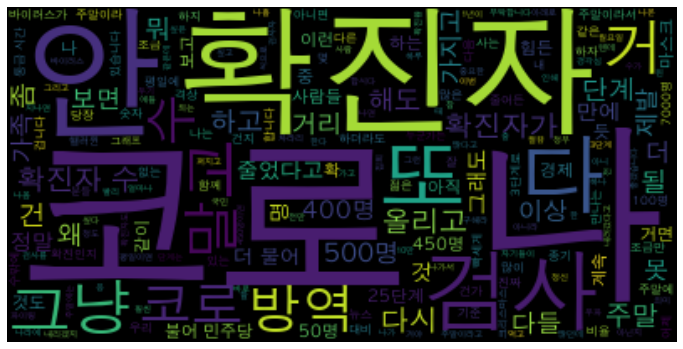

In [202]:
# http://deepsix2757.blogspot.com/2018/07/python-wordcloud.html
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image

wordcloud = WordCloud(font_path="/Library/Fonts/AppleGothic.ttf", 
                                        background_color="black", 
                                        relative_scaling=0.2)
wordcloud.generate(all_comments)
 
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

In [203]:
# 10 most liked comments
like10 = cmts.sort_values(by=['Like'], ascending=False)
like10.index = range(0, len(like10))
like10.head(10)

,ID,Comment,Like,Lang
0,주녀니,엊그제 22000명 500명 어제 14000명 450명 단순 비율 계산을 하더라도 ...,47,k
1,이민한,주말은 검사소 자체가 반 이상 쉰다,45,k
2,신라면보다진라면,주말이라서 그렇겠지 평일에 한번 봐야 알듯 확진자가 많이 줄어들었으면 좋겠는데 확...,42,k
3,허진혁,경제 경제 거릴 거면 기준 왜 만든 건데 25단계 기준 넘었으면 입 다 물고 격상해...,40,k
4,Raeme Wu,방역 잘했다고 자랑질 그만합시다 100명 이하로 줄어야 안심이 되지 그리고 코로 나...,39,k
5,황구렁이뚤딸이,언론의 역할도 되게 중요한 거 같습니다 제목만 보면 코로 나가 진정세인 줄 알겠습니...,39,k
6,BJ칼빵,겨우 50명 줄어든 거 가지고 호들갑 떠냐 100명 이상 줄어야지,35,k
7,참견의정도,쩜 오 말고 그냥 3단계로 빡세게,20,k
8,은꽃,검사 숫자 대비 확진자 발표를 하셔야죠 5000명 검사 중 450명 확진인지 700...,20,k
9,날조쟁이_개소리꾼,킨텍스 코엑스 이런 곳도 제재해야 한다 고주몽,16,k


In [182]:
# 좋아요 개수 20개 이상의 댓글들로만 word cloud 

like20_comments = ''
for comment in list(like10['Comment'].loc[:19]):
    like20_comments+= comment + " "

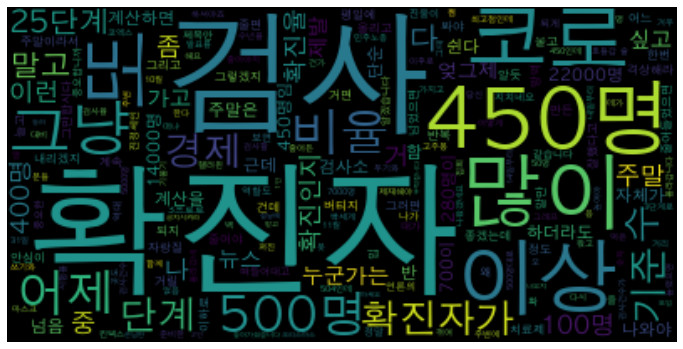

In [184]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image
wordcloud = WordCloud(font_path="/Library/Fonts/AppleGothic.ttf", 
                                        background_color="black", 
                                        relative_scaling=0.2)
wordcloud.generate(like20_comments)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

In [205]:
# with weight about likes
all_comments = ''
for i in range(len(cmts)):
    all_comments+= (cmts['Comment'].loc[i] + " ")*cmts['Like'].loc[i]

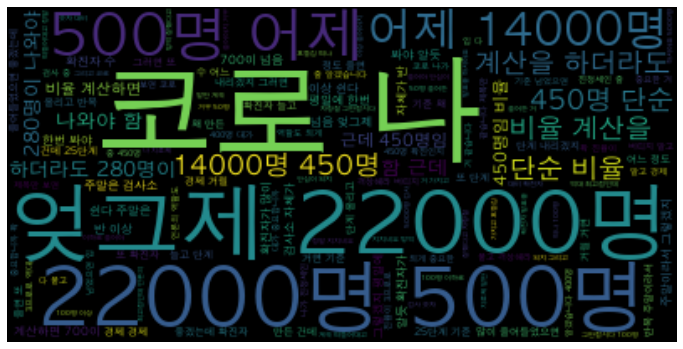

In [206]:
# http://deepsix2757.blogspot.com/2018/07/python-wordcloud.html
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image

wordcloud = WordCloud(font_path="/Library/Fonts/AppleGothic.ttf", 
                                        background_color="black", 
                                        relative_scaling=0.2)
wordcloud.generate(all_comments)
 
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

In [207]:
# 좋아요 개수 20개 이상의 댓글들로만 word cloud 
# with weight about like 
like20_comments = ''
for i in range(20):
    like20_comments+= (like10['Comment'].loc[i] + " ")*like10['Like'].loc[i]

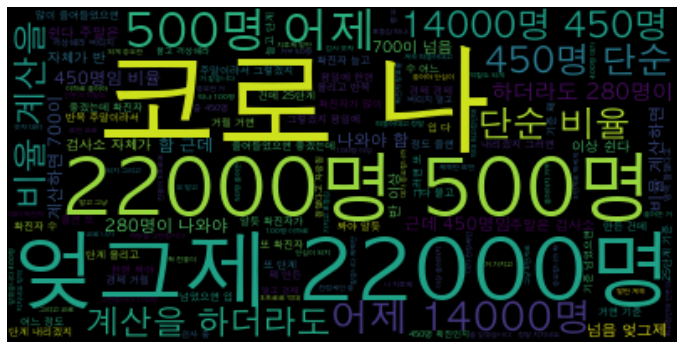

In [208]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from PIL import Image


wordcloud = WordCloud(font_path="/Library/Fonts/AppleGothic.ttf", 
                                        background_color="black", 
                                        relative_scaling=0.2)
wordcloud.generate(like20_comments)
 
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

### sentimental analysis

- 네이버 평점 분석 데이터셋으로 학습했던, [기존의 감정분석 딥러닝 코드](https://nbviewer.jupyter.org/github/cyc1am3n/Deep-Learning-with-Python/blob/master/Chap03-getting_started_with_neural_networks/Chap03-Extra-classifying_korean_movie_review.ipynb) 응용
        - dataset: https://github.com/e9t/nsmc/
    - 0~1의 범위로, 얼마나 positive 한지 scoring

In [73]:
# data download
! git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 6.84 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Updating files: 100% (14737/14737), done.


In [79]:
!pwd

/Users/midan/_midanniiii/2020-2/datascience_vi/project


In [82]:
# data load
def read_data(filename):
    with open(filename, 'r') as f: #데이터 f 함수를 이용하여 불러오기
        data = [line.split('\t') for line in f.read().splitlines()] 
        #f 함수를 이용하여 먼저 줄별로 split한 데이터를 반복문을 통해서 띄어쓰기를 구분자로 split한 것을 리스트로 반환
    
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data
    
train_df = read_data('./nsmc/ratings_test.txt')
test_df = read_data('./nsmc/ratings_test.txt')

In [83]:
# 불러온 데이터의 review부분을 tokenize
from konlpy.tag import Okt
import json
import os
from pprint import pprint

#밑의 tokenizing함수를 이해하기 편하도록 들어놓은 예시 
#tokenizing함수의 반복문 구조를 보시면 아래에 나온 결과를 반복문으로 '/'를 구분자로 결합시킵니다.
okt = Okt()
okt.pos('당신을 보고 있으니 정말로 기분이 좋아집니다') 

# 하나의 문장을 토큰화 한 후 텍스트와 품사태깅을 / 구분자로 묶어준다.
def tokenizing(docs):
    return ['/'.join(t) for t in okt.pos(docs,norm=True, stem=True)]
    
train_pos = [] #훈련데이터
test_pos = [] #테스트 데이터
for row in train_df:
    try:
        train_pos0 = [tokenizing(row[1]),row[2]] 
        #리스트 안에 한문장에 대해서 위에서 만든 tokenizing함수를 통해서 [[토큰화텍스트],긍/부정 여부]를
        #리스트의 각문장별로 요소로 넣는다.
        train_pos.append(train_pos0)
    except:
        pass
    
for row in test_df:
    try:
        test_pos0 = [tokenizing(row[1]),row[2]] 
        test_pos.append(test_pos0)
    except:
        pass

In [84]:
# 데이터 전처리 및 EDA

#위에서 만든 데아터에서 긍/부정을 제외하고 token에 넣어준다. [[a],b] 에서 a만 넣는다고 생각하면 됨
tokens = [t for d in train_pos for t in d[0]]

import nltk
text = nltk.Text(tokens,name='NMSC')#nltk라이브러리를 통해서 텍스트 데이터 나열

len(set(text.tokens))#35425개의 고유 텍스트가 존재

text.vocab().most_common(10) #vocab().most_common(10) - 텍스트 빈도 상위 10개 보여주기 즉, count_values()를 통해서 내림차순한 것과 같습니다.

[('./Punctuation', 22621),
 ('영화/Noun', 17328),
 ('하다/Verb', 13750),
 ('이/Josa', 13105),
 ('보다/Verb', 12840),
 ('의/Josa', 10147),
 ('../Punctuation', 9590),
 ('에/Josa', 9044),
 ('가/Josa', 8892),
 ('.../Punctuation', 7717)]

In [85]:
#단어 빈도수가 높은 10000개의 단어만 사용하여 각 리뷰 문장마다의 평가지표로 삼는다.
selected_words = [f[0] for f in text.vocab().most_common(10000)]

#term_frequency()함수는 위에서 만든 selected_words의 갯수에 따라서 각 리뷰와 매칭하여 상위 텍스트가 
#각 리뷰에 얼만큼 표현되는지 빈도를 만들기 위한 함수
def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_pos]
#train_x만 설명하자면 위의 결과로 도출되는 train_x의 구조는 아래와 같다
#[[1번째리뷰를 상위 10000개와 각각 매칭하여 각 10000개의 단어가 해당 문장에 얼마나 포함되는지를 확인]]
#리스트 차원으로 표현하면 [[10000개],[10000개],[10000개]....[10000개]] 가장 바깥 리스트의 갯수는 기존 train_pos의 리뷰 갯수와 같다.
test_x = [term_frequency(d) for d, _ in test_pos]
train_y = [c for _, c in train_pos] #train_pos데이터에서 각 리뷰별 긍/부정 여부 데이터이므로 train_pos의 리뷰갯수와 같은 사이즈이다.
test_y = [c for _, c in test_pos]

In [86]:
##모델링을 하기 위해 리스트로 되어 있는 데이터 형식을 array로 바꿔주고 dtype도 실수로 바꿔준다.
x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [87]:
## 감정분석 모델링

# 1. 맨 상단의 두 개 dense층은 64개의 유닛을 가지고 relu활성화함수사용
# 2.마지막 층은 1개의 유닛으로 시그모이드 활성화함수를 사용하여 - 즉 긍정의 리뷰일 확률을 출력한다. (부정의 리뷰일 확률은 어떻게 추출하지?)
# 3. 손실함수로 binary_crossentropy사용 / rmsprop 옵티마이저를 통해서 경사하강법 진행

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

#tensorflow.keras를 활용하여 모델의 층 입력하기
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))#10000개를 추출했으므로 shape는10000
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#모델 생성
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])
             
#모델 학습
model.fit(x_train, y_train, epochs=10, batch_size=512)
results = model.evaluate(x_test, y_test)

#예측 결과
results #83%의 정확도를 가진다.

Epoch 1/10
98/98 [==============================] - 3s 27ms/step - loss: 0.4530 - binary_accuracy: 0.8068
Epoch 2/10
98/98 [==============================] - 2s 19ms/step - loss: 0.3369 - binary_accuracy: 0.8576
Epoch 3/10
98/98 [==============================] - 2s 18ms/step - loss: 0.3007 - binary_accuracy: 0.8731
Epoch 4/10
98/98 [==============================] - 2s 19ms/step - loss: 0.2695 - binary_accuracy: 0.8866
Epoch 5/10
98/98 [==============================] - 51s 517ms/step - loss: 0.2406 - binary_accuracy: 0.900813s - loss: 0.2326 - b
Epoch 6/10
98/98 [==============================] - 2s 21ms/step - loss: 0.2136 - binary_accuracy: 0.9150
Epoch 7/10
98/98 [==============================] - 2s 16ms/step - loss: 0.1885 - binary_accuracy: 0.9265
Epoch 8/10
98/98 [==============================] - 26s 266ms/step - loss: 0.1661 - binary_accuracy: 0.9374
Epoch 9/10
98/98 [==============================] - 2s 18ms/step - loss: 0.1450 - binary_accuracy: 0.9471
Epoch 10/10
1563/156

[0.09659130871295929, 0.9689599871635437]

### 학습한 모델을 바탕으로, 감정분석 진행 

In [103]:
def predict_pos_text(text):
    token = tokenizing(text) #okt.pos로 토큰화한 단어를 정리
    tf =term_frequency(token)#토큰화된 단어를 이용해서 가장 많이 등장하는 단어와의 빈도수 체크

    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    #data는 그럼 입력받는 text가 한 문장만 받기 때문에 가장 바깥 리스트의 요소 갯수는 1이 될 것이고
    #마찬가지로 리스트 안 리스트 요소내의 갯수는 10000개가 될 것이다.
    #np.expand_dims?? 
    score = float(model.predict(data)) #새로운 데이터를 받으면 결과 예측
    #if(score > 0.5):
    #    print("[{}]는 {:.2f}% 확률로 긍정 리뷰입니다.\n".format(text, score * 100))
    #else:
    #    print("[{}]는 {:.2f}% 확률로 부정 리뷰입니다.\n".format(text, (1 - score) * 100))
    return score

In [185]:
for i in range(5):
    print(predict_pos_text(comments[i]))

0.983062744140625
3.4480468258379915e-08
0.11967000365257263
0.942197322845459
0.903623104095459


In [200]:
## English version
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
neg = []
neu = []
pos = []
compound = []

analyzer = SentimentIntensityAnalyzer()
for temp in after_cleansing:
    vs = analyzer.polarity_scores(temp)
    neg.append(vs['neg'])
    pos.append(vs['pos'])
    neu.append(vs['neu'])
    compound.append(vs['compound'])
    
senti = pd.DataFrame( {
    'negative': neg, 'neutral': neu, 'positive':pos, 'compound':compound
} )    

In [221]:
senti_scores = []

for i in range(len(cmts)):
    temp = [predict_pos_text(cmts['Comment'].loc[i])]*cmts['Like'].loc[i] # 한글 
    for t in temp: senti_scores.append(t)

In [223]:
# visualization
def my_plot(title_name, data_list):
    #plt.hist(data_list, range=(0,1), bins=25)
    plt.title(title_name)
    plt.xlabel('<--     negative            [scores]             positive     -->')
    plt.ylabel('count')
    # Plot histogram.
    cm = plt.cm.get_cmap('RdYlBu_r')
    n, bins, patches = plt.hist(data_list, 25, color='green', alpha = 0.8, edgecolor = 'black', linewidth = 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

    plt.show()

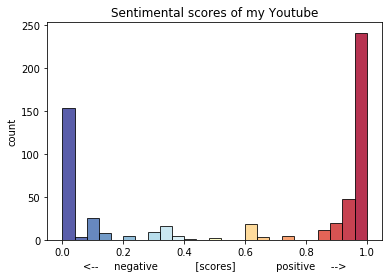

In [224]:
my_plot('Sentimental scores of my Youtube', senti_scores)